<a href="https://colab.research.google.com/github/Naveensadanandan/Pytorch/blob/main/02_Neural_network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Make classification data and get it ready

In [ ]:
from sklearn.datasets import make_circles


# Make 10000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.05, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [ ]:
print(f"values in X : {X[:5]}")
print(f"dtype in X : {type(X)}")
print(f"shape of X : {X.shape}")

values in X : [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
dtype in X : <class 'numpy.ndarray'>
shape of X : (1000, 2)


In [ ]:
print(f"values in y : {y[:5]}")
print(f"dtype in y : {type(y)}")
print(f"shape of y : {y.shape}")

values in y : [1 1 1 1 0]
dtype in y : <class 'numpy.ndarray'>
shape of y : (1000,)


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


In [ ]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


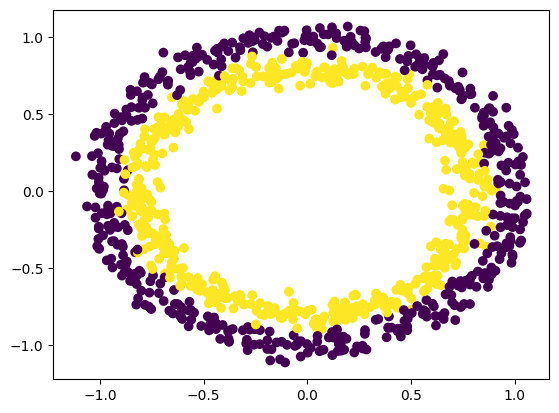

In [ ]:
#plotting data points|
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y)
plt.show()

##  1.1 Input and output shapes

In [ ]:
print(f"shape of X : {X.shape}")
print(f"shape of y : {y.shape}")

shape of X : (1000, 2)
shape of y : (1000,)


## Convering data to tensors

In [ ]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(X[0])

tensor([0.7422, 0.2467])


In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building a model

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Defining the model

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10,out_features=10)
    self.layer3 = nn.Linear(in_features=10,out_features=1)

  def forward(self, X):
    return self.layer3(self.layer2(self.layer1(X)))

model_1 = CircleModelV0().to(device)

In [ ]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, 

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):

  model_1.train()

  #1.forward
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2.loss

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  #3. zero grad
  optimizer.zero_grad()

  #4. backpropogation
  loss.backward()

  #5.gradient descent

  optimizer.step()

  #testing
  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    # Print out what's happening every 10 epochs
    if epoch % 500 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69393, Accuracy: 51.00% | Test loss: 0.69264, Test acc: 50.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69465, Test acc: 45.50%


# Creating a model with non linear activation function

In [ ]:
import torch
from torch import nn

class CircleModelV1(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
     super().__init__(*args, **kwargs)
     self.layer1 = nn.Linear(in_features=2, out_features=10)
     self.layer2 = nn.Linear(in_features=10, out_features=10)
     self.layer3 = nn.Linear(in_features=10, out_features=1)
     self.relu = nn.ReLU()

  def forward(self, x):
    z = self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    return z

model_2 = CircleModelV1()
model_2.to(device)

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

epochs = 10000

for epoch in range(epochs):
  model_2.train()

  y_logits = model_2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred= y_preds, y_true = y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_pred= test_preds, y_true = y_test)

    if epoch%250 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69329, Test acc: 50.00%
Epoch: 250 | Loss: 0.68891, Accuracy: 53.25% | Test loss: 0.68882, Test acc: 55.00%
Epoch: 500 | Loss: 0.68126, Accuracy: 53.62% | Test loss: 0.68084, Test acc: 56.00%
Epoch: 750 | Loss: 0.66143, Accuracy: 60.12% | Test loss: 0.66117, Test acc: 62.00%
Epoch: 1000 | Loss: 0.57644, Accuracy: 84.62% | Test loss: 0.58984, Test acc: 84.00%
Epoch: 1250 | Loss: 0.35028, Accuracy: 95.50% | Test loss: 0.41782, Test acc: 87.50%
Epoch: 1500 | Loss: 0.17570, Accuracy: 97.38% | Test loss: 0.26573, Test acc: 91.00%
Epoch: 1750 | Loss: 0.11318, Accuracy: 98.00% | Test loss: 0.20154, Test acc: 92.50%
Epoch: 2000 | Loss: 0.08736, Accuracy: 98.25% | Test loss: 0.17352, Test acc: 93.50%
Epoch: 2250 | Loss: 0.07416, Accuracy: 98.25% | Test loss: 0.15927, Test acc: 94.00%
Epoch: 2500 | Loss: 0.06655, Accuracy: 98.38% | Test loss: 0.15168, Test acc: 93.50%
Epoch: 2750 | Loss: 0.06170, Accuracy: 98.25% | Test loss: 0.14761, Tes

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


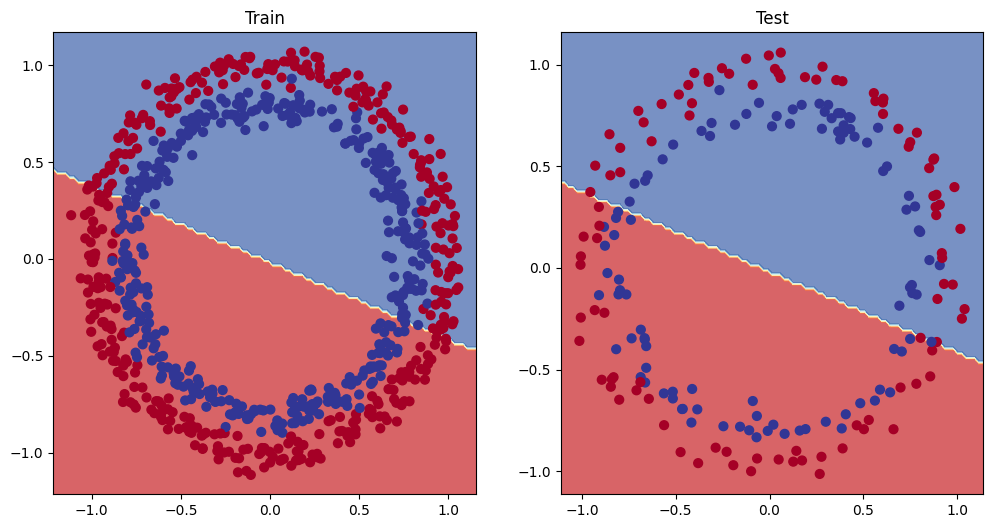

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

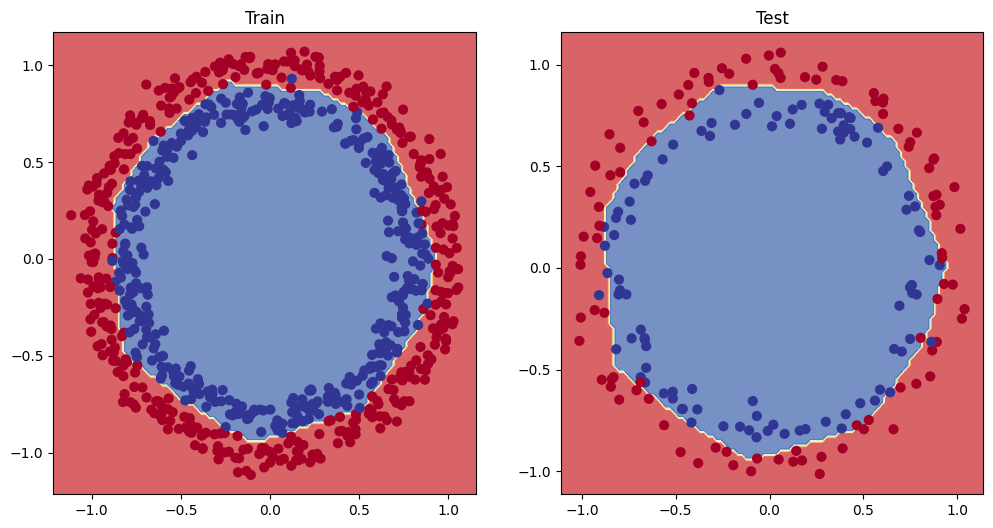

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)